In [1]:
import logging
import time

import config
import modules.classification_dataloader as classification_loader

from tqdm import tqdm

import onnx
import onnxruntime

import numpy as np
import torch
import torchmetrics

import matplotlib.pyplot as plt

# Logger

In [2]:
log_path = 'experiments/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + '02_classification_logfile_final_models_dfire_mini.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('Eval ONNX Classifiers.\n' + 
            '\tBED compressed and quantized, Mobilenet, ShuffleNet, SqueezeNet.')

# Dataset Dfire Mini

## Dataloader

In [3]:
val_loader = classification_loader.get_val_loader(shuffle=False)


TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 20
DFire only smoke images: 45
DFire only fire images: 5
DFire smoke and fire images: 30

Test dataset len: 100


## Plot Dataset Pictures

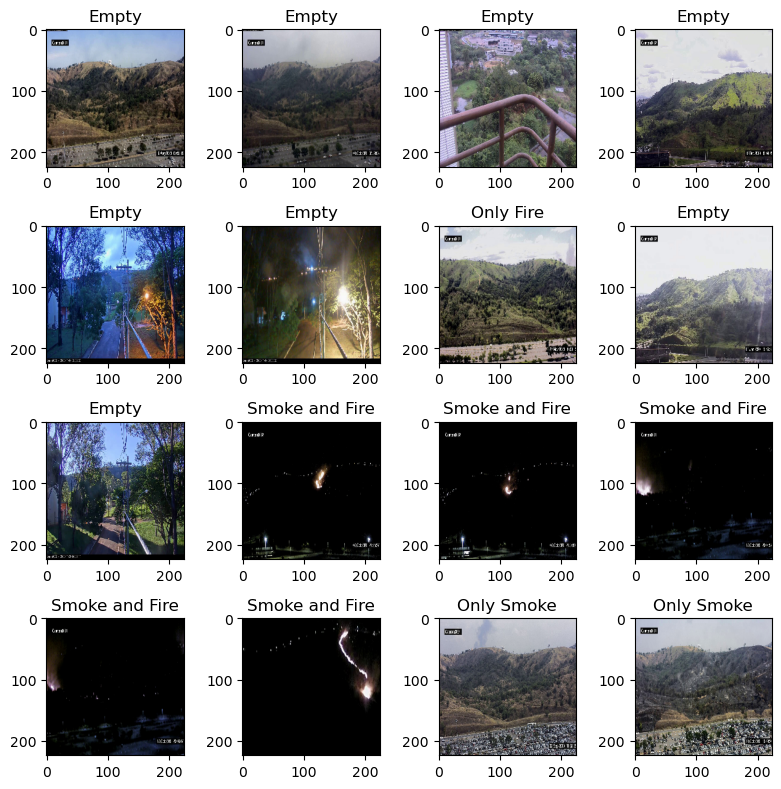

In [4]:
plt.subplots(4,4, figsize=(8, 8))

for batch_idx, (img, label) in enumerate(val_loader):
              
    for idx in range(config.BATCH_SIZE):
        plt.subplot(4, 4, batch_idx*config.BATCH_SIZE + idx + 1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (batch_idx*config.BATCH_SIZE + idx + 1 == 16):
            break
    
    if (batch_idx*config.BATCH_SIZE + idx + 1 == 16):
        plt.tight_layout()
        plt.show()
        break

# ONNX 

## Load & Check

In [5]:
onnx_dir = './onnx_classification_models/'

bed_dir = onnx_dir + 'final_models/'
bed_no_comp_onnx_path = bed_dir + 'BED__no_comp__best_mean_f1__cpu.onnx'
bed_aimet_onnx_path = bed_dir + 'BED__med_comp__341_big__best_mean_f1__cpu.onnx'

mobilenet_onnx_path = onnx_dir + 'mobilenet_classifier.onnx'
shufflenet_onnx_path = onnx_dir + 'shufflenet_classifier.onnx'
squeezenet_onnx_path = onnx_dir + 'squeezenet_classifier.onnx'

## BED NO COMP Classifier

In [6]:
bed_no_comp_classifier = onnx.load(bed_no_comp_onnx_path)
onnx.checker.check_model(bed_no_comp_classifier)

### BED AIMET Classifier: compressed and quantized

In [7]:
bed_aimet_classifier = onnx.load(bed_aimet_onnx_path)
onnx.checker.check_model(bed_aimet_classifier)

### MobileNet Classifier

In [8]:
mobilenet_classifier = onnx.load(mobilenet_onnx_path)
onnx.checker.check_model(mobilenet_classifier)

### ShuffleNet Classifier

In [9]:
shufflenet_classifier = onnx.load(shufflenet_onnx_path)
onnx.checker.check_model(shufflenet_classifier)

## SqueezeNet Classifier

In [10]:
squeezenet_classifier = onnx.load(squeezenet_onnx_path)
onnx.checker.check_model(squeezenet_classifier)

## Metrics to CPU for ONNX evaluation

In [11]:
precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = config.N_CLASSES, 
                                                                   threshold = 0.5, 
                                                                   average = None).to('cpu')
recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = config.N_CLASSES, 
                                                             threshold = 0.5, 
                                                             average = None).to('cpu')
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = config.N_CLASSES, 
                                                                 threshold = 0.5, 
                                                                 average = None).to('cpu')
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = config.N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = None).to('cpu')

f1_metric_mean = torchmetrics.classification.MultilabelF1Score(num_labels = config.N_CLASSES, 
                                                               threshold = 0.5, 
                                                               average = 'macro').to('cpu')

## Eval Function

In [12]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

In [13]:
def eval_classifier_onnx(loader, model_name):

    ort_session = onnxruntime.InferenceSession(model_name, providers=["CPUExecutionProvider"])

    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    f1_metric_mean.reset()
    
    loop = tqdm(loader, desc='Validating', leave=True)
    
    loop_i = 0
    loop_times = []

    for batch_idx, (img, label) in enumerate(loop):

        for idx in range(config.BATCH_SIZE):
            
            ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img[idx].unsqueeze(dim=0))}
            
            start = time.perf_counter_ns()
            
            yhat = ort_session.run(None, ort_inputs)
            
            end = time.perf_counter_ns()
            pred_time = end-start
            
            yhat = np.array(yhat)
            #yhat = torch.tensor(yhat).squeeze(dim=0)
            yhat = torch.sigmoid(torch.tensor(yhat).squeeze(dim=0))
            target = label[idx].unsqueeze(dim=0)

            precision_metric.update(yhat, target)
            recall_metric.update(yhat, target)
            accuracy_metric.update(yhat, target)
            f1_metric.update(yhat, target)
            f1_metric_mean.update(yhat, target)
            
            loop_i += 1
            loop_times.append(pred_time)
    
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()
    f1_mean = f1_metric_mean.compute()

    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    f1_metric_mean.reset()
    
    mean_pred_time = ( sum(loop_times) / len(loop_times) ) * 1e-6

    print(f'SMOKE -> Precision: {precision[0]:.4f} - Recall: {recall[0]:.4f} - Accuracy: {accuracy[0]:.4f} - F1: {f1[0]:.4f}')
    print(f'FIRE -> Precision: {precision[1]:.4f} - Recall: {recall[1]:.4f} - Accuracy: {accuracy[1]:.4f} - F1: {f1[1]:.4f}')
    print(f'Mean F1 Score: {f1_mean.item():.4f}')
    print(f'Mean Pred Time: {mean_pred_time:.3f} ms')

    logger.info(f'\tSMOKE -> Precision: {precision[0]:.4f} - Recall: {recall[0]:.4f} - Accuracy: {accuracy[0]:.4f} - F1: {f1[0]:.4f}')
    logger.info(f'\tFIRE -> Precision: {precision[1]:.4f} - Recall: {recall[1]:.4f} - Accuracy: {accuracy[1]:.4f} - F1: {f1[1]:.4f}')
    logger.info(f'\tMean F1 Score: {f1_mean.item():.4f}')
    logger.info(f'\tMean Pred Time: {mean_pred_time:.3f} ms')
    
    return (
        loop_times,
        {
        'Accuracy': [accuracy[0].item(), accuracy[1].item()],
        'Precision': [precision[0].item(), precision[1].item()],
        'Recall': [recall[0].item(), recall[1].item()],
        'F1': [f1[0].item(), f1[1].item()],
        'F1 mean': f1_mean.item(),
        }
    )

## BED No Comp Evaluation

In [14]:
logger.info("\nBED NO COMP ONNX Metrics")
bed_no_comp_time, bed_no_comp_onnx_metrics = eval_classifier_onnx(val_loader, bed_no_comp_onnx_path)

Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 168.62it/s]

SMOKE -> Precision: 0.9851 - Recall: 0.8800 - Accuracy: 0.9000 - F1: 0.9296
FIRE -> Precision: 0.9706 - Recall: 0.9429 - Accuracy: 0.9700 - F1: 0.9565
Mean F1 Score: 0.9430
Mean Pred Time: 2.286 ms


## BED AIMET Evaluation

In [15]:
logger.info("\nBED AIMET ONNX Metrics")
bed_aimet_time, bed_aimet_onnx_metrics = eval_classifier_onnx(val_loader, bed_aimet_onnx_path)

Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 170.72it/s]

SMOKE -> Precision: 0.9853 - Recall: 0.8933 - Accuracy: 0.9100 - F1: 0.9371
FIRE -> Precision: 0.9714 - Recall: 0.9714 - Accuracy: 0.9800 - F1: 0.9714
Mean F1 Score: 0.9542
Mean Pred Time: 2.005 ms


## MobileNet Evaluation

In [16]:
logger.info("\nMobilenet ONNX Metrics")
mobilenet_time, mobilenet_onnx_metrics = eval_classifier_onnx(val_loader, mobilenet_onnx_path)

Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 174.56it/s]

SMOKE -> Precision: 0.9867 - Recall: 0.9867 - Accuracy: 0.9800 - F1: 0.9867
FIRE -> Precision: 0.9688 - Recall: 0.8857 - Accuracy: 0.9500 - F1: 0.9254
Mean F1 Score: 0.9560
Mean Pred Time: 2.136 ms


## ShuffleNet Evaluation

In [17]:
logger.info("\nShufflenet ONNX Metrics")
shufflenet_time, shufflenet_onnx_metrics = eval_classifier_onnx(val_loader, shufflenet_onnx_path)

Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 182.69it/s]

SMOKE -> Precision: 0.9610 - Recall: 0.9867 - Accuracy: 0.9600 - F1: 0.9737
FIRE -> Precision: 0.9688 - Recall: 0.8857 - Accuracy: 0.9500 - F1: 0.9254
Mean F1 Score: 0.9495
Mean Pred Time: 2.341 ms


## SqueezeNet Evaluation

In [18]:
logger.info("\nSqueezenet ONNX Metrics")
squeezenet_time, squeezenet_onnx_metrics = eval_classifier_onnx(val_loader, squeezenet_onnx_path)

Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 109.73it/s]

SMOKE -> Precision: 0.9722 - Recall: 0.9333 - Accuracy: 0.9300 - F1: 0.9524
FIRE -> Precision: 0.9714 - Recall: 0.9714 - Accuracy: 0.9800 - F1: 0.9714
Mean F1 Score: 0.9619
Mean Pred Time: 7.241 ms
